In [8]:
import QuantLib as ql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import newton

# Market

In [9]:
evaluation_date = ql.Date(30,4,2024)
ql.Settings.instance().evaluationDate = evaluation_date

######################################
###### ESTR ##########################

# curva eur estr mx
df_estr = pd.read_excel('data/market_20240430.xlsx', 
                   sheet_name=0,
                   usecols="M:O",
                   skiprows=1).dropna()
times_estr = df_estr['times'].astype(int).values
dfs_estr = df_estr['discount'].values
rates_estr = df_estr['rate'].values
dates_estr = evaluation_date + times_estr

discount_curve_estr = ql.DiscountCurve(dates_estr, dfs_estr, ql.Actual360(), ql.TARGET())
discount_curve_estr.enableExtrapolation()
yts_estr_mx = ql.YieldTermStructureHandle(discount_curve_estr)


######################################
###### CR ##########################

df_estr_isda = pd.read_excel('data/market_20240430.xlsx', 
                                sheet_name=1,
                                usecols="M:N",
                                skiprows=1).dropna()
times_estr_isda = df_estr_isda['times'].astype(int).values
spread_cr_estr = df_estr_isda['spread'].values
dates_cr = evaluation_date + times_estr_isda

# backward flat ql
hazard_rates = spread_cr_estr #+ ((146.5516901) / 10000)
pd_curve = ql.HazardRateCurve(dates_cr, hazard_rates, ql.Actual360())
pd_curve.enableExtrapolation()
yts_cr_mx = ql.DefaultProbabilityTermStructureHandle(pd_curve)

# linear
pd_curve_mx_lin = ql.ZeroCurve(dates_cr, hazard_rates, ql.Actual360(), ql.TARGET())
pd_curve_mx_lin.enableExtrapolation()
yts_cr_lin_mx = ql.YieldTermStructureHandle(pd_curve_mx_lin)


In [10]:
taus = np.linspace(0,30*365, 3000)
taus = [int(t) for t in taus]
taus = np.array(taus)


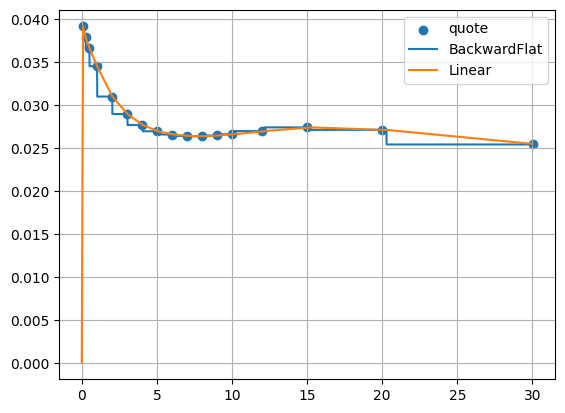

In [11]:
hazard_ql = [yts_cr_mx.hazardRate(t/365) for t in taus[1:]]
hazard_linear = [yts_cr_lin_mx.zeroRate(t/365, ql.Continuous).rate() for t in taus]

plt.scatter(times_estr_isda[1:]/365, spread_cr_estr[1:], label = 'quote')
plt.plot(taus[1:]/365, hazard_ql, label = 'BackwardFlat')
plt.plot(taus/365, hazard_linear, label = 'Linear')

plt.legend()
plt.grid()
plt.show()

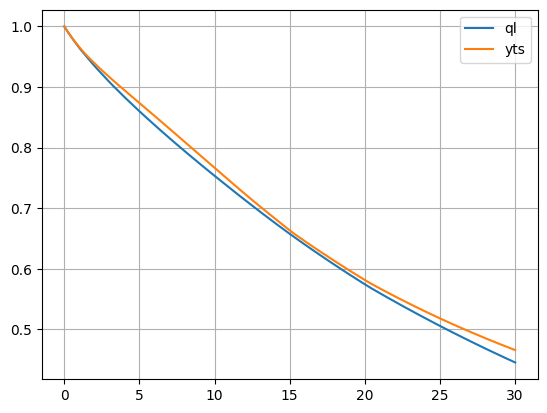

In [12]:
survival_ql = [yts_cr_mx.survivalProbability(t/365) for t in taus] 
survival_ql_rep1 = [np.exp(-(t/365)*yts_cr_lin_mx.zeroRate(t/365, ql.Continuous).rate()) for t in taus] 

plt.plot(taus/365, survival_ql, label = 'ql')
plt.plot(taus/365, survival_ql_rep1, label = 'yts')

plt.legend()
plt.grid()
plt.show()

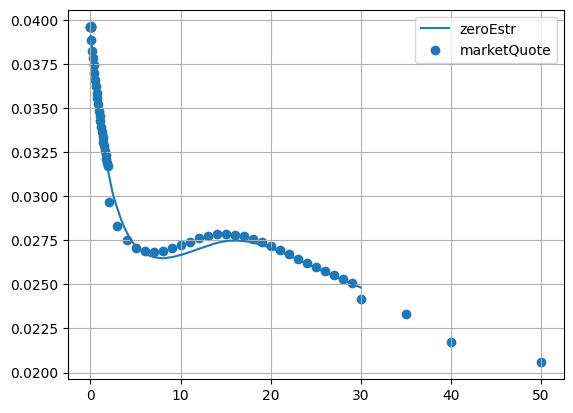

In [13]:
test_estr_rates = [yts_estr_mx.zeroRate(t/365, ql.Continuous).rate() for t in taus]
plt.plot(taus/365, test_estr_rates, label = 'zeroEstr')
plt.scatter(times_estr/365, rates_estr/100, label = 'marketQuote')

plt.legend()
plt.grid()
plt.show()

# BTP-ita 52: IT0005480980

In [14]:
class FixedBondPricer:

    def __init__(self, 
                 bond: ql.FixedRateBond,
                 yts_estr: ql.YieldTermStructureHandle,
                 yts_cr: ql.YieldTermStructureHandle # è una zero curve per interpolare linearmente
                 ) -> None:
        self.bond = bond
        self.yts_estr = yts_estr
        self.yts_cr = yts_cr

    def evaluation_flows(self, spread_theo: float):
        ''' 
        Flussi del bond teorico 
        '''
        dates_bond = []
        amounts_bond = []
        zero_spreads = []
        zero_rates = []
        times = []
        spread_over_yields = []
        npv_date = self.yts_estr.referenceDate()

        for cf in self.bond.cashflows():
            d2 = cf.date()
            if d2 > npv_date:
                tau = self.bond.dayCounter().yearFraction(npv_date, cf.date())
                times.append(tau)
                dates_bond.append(cf.date())
                amounts_bond.append(cf.amount())
                spread_over_yields.append(spread_theo)
                zero_spreads.append(self.yts_cr.zeroRate(tau,  ql.Continuous).rate())
                zero_rates.append(self.yts_estr.zeroRate(tau,  ql.Continuous).rate())

        
        bond_flows = pd.DataFrame([dates_bond,
                                    times,
                                    amounts_bond,
                                    spread_over_yields,
                                    zero_spreads,
                                    zero_rates], 

                                    index=["dates",
                                            "times",
                                            "amount",
                                            "spread_theo",
                                            "zero_spreads",
                                            "zero_rates"
                                            ]).T
        
        bond_flows['discount_rate'] = bond_flows['zero_rates'] + bond_flows['zero_spreads'] + bond_flows['spread_theo']
        bond_flows['discounted_amount'] = np.exp(- bond_flows['times'].astype(float) *bond_flows['discount_rate'].astype(float) ) * bond_flows['amount']
        return bond_flows
    
    @staticmethod
    def calc_hazard_rate(cr_spread: float, spread_margin: float):
        return cr_spread + spread_margin #/(1-recovery) + spread_margin

    @staticmethod
    def calc_survival(hazard_rate: float, accrual_time: float):
        return np.exp(- hazard_rate * accrual_time)
    
    def price_defaultable(self, spread_margin: float, recovery_rate: float, mtm_mode: bool = False, mtm_price: float = 0.0):

        if mtm_mode:
            spread_0 = 0
            tolerance = 1e-7
            spread_margin = newton(lambda spread: self.price_defaultable(spread, recovery_rate)[0] - mtm_price, 
                                   spread_0, tol=tolerance)

        npv_date = self.yts_estr.referenceDate()
        d1 = max(npv_date, self.bond.startDate())
        default_leg = 0
        coupon_leg = 0
        for cf in self.bond.cashflows():
            d2 = cf.date()
            if d2 > npv_date:
                t1 = self.bond.dayCounter().yearFraction(npv_date, d1)
                t2 = self.bond.dayCounter().yearFraction(npv_date, d2)
                ## componenti
                df1 = self.yts_estr.discount(d1)
                df2 = self.yts_estr.discount(d2)
                hazard_rate_t1 = self.calc_hazard_rate(self.yts_cr.zeroRate(t1,  ql.Continuous).rate(),
                                                         spread_margin)
                hazard_rate_t2 = self.calc_hazard_rate(self.yts_cr.zeroRate(t2,  ql.Continuous).rate(),
                                                         spread_margin)
                ndp1 = self.calc_survival(hazard_rate_t1, t1)
                ndp2 = self.calc_survival(hazard_rate_t2, t2)
                tau = self.bond.dayCounter().yearFraction(d1, d2)

                fds = np.log(ndp1/ndp2) / tau
                fdr = np.log(df1/df2) / tau
                # survival part 
                weighted_coupon_amount = cf.amount() * ndp2
                coupon_leg += weighted_coupon_amount * df2
                # default part 
                
                default_factor = (fds / (fdr + fds)) * (df1*ndp1 - df2*ndp2) # D_2(t, t+1)
                weighted_recovery = self.bond.notional() * recovery_rate * default_factor
                default_leg += weighted_recovery 

                if d2 == self.bond.cashflows()[-1].date():
                    d1 = self.bond.cashflows()[-3].date()
                else:
                    d1 = d2
        npv = coupon_leg + default_leg
        return npv, coupon_leg, default_leg, spread_margin
    
    def cr_zero_one(self, 
                    spread_margin: float,
                    recovery_rate: float,
                    mtm_mode: bool = False,
                    mtm_price: float = 0.0):
        
        delta1 = 0.0001 

        if mtm_mode:
            p_0 = mtm_price
            spread_margin = self.price_defaultable(spread_margin, recovery_rate, mtm_mode, mtm_price)[3]
        else: 
            p_0 = self.price_defaultable(spread_margin, recovery_rate)[0]

        p_delta = self.price_defaultable(spread_margin + delta1, recovery_rate)
        cr01 = (p_delta[0] - p_0)
        return cr01

    def defaultable_flows(self, spread_margin: float, recovery_rate: float):

        npv_date = self.yts_estr.referenceDate()
        d1 = max(npv_date, self.bond.startDate())
        default_leg = 0
        coupon_leg = 0
        prev_dates_bond = []
        dates_bond = []
        tau_bond = []
        amount_bond = []
        discount_factors = []
        survival = []
        recovered_amount = []
        default_prob_D2 = []
        default_npv = []
        for cf in self.bond.cashflows():
            d2 = cf.date()
            if d2 > npv_date:
                dates_bond.append(d2)
                prev_dates_bond.append(d1)
                t1 = self.bond.dayCounter().yearFraction(npv_date, d1)
                t2 = self.bond.dayCounter().yearFraction(npv_date, d2)
                ## componenti
                df1 = self.yts_estr.discount(d1)
                df2 = self.yts_estr.discount(d2)
                hazard_rate_t1 = self.calc_hazard_rate(self.yts_cr.zeroRate(t1,  ql.Continuous).rate(),
                                                         spread_margin)
                hazard_rate_t2 = self.calc_hazard_rate(self.yts_cr.zeroRate(t2,  ql.Continuous).rate(),
                                                         spread_margin)
                ndp1 = self.calc_survival(hazard_rate_t1, t1)
                ndp2 = self.calc_survival(hazard_rate_t2, t2)
                tau = self.bond.dayCounter().yearFraction(d1, d2)
                tau_bond.append(tau)
                fds = np.log(ndp1/ndp2) / tau
                fdr = np.log(df1/df2) / tau
                # survival part 
                amount_bond.append(cf.amount())
                discount_factors.append(df2)
                survival.append(ndp2)
                weighted_coupon_amount = cf.amount() * ndp2
                coupon_leg += weighted_coupon_amount * df2
                # default part 
                default_factor = (fds / (fdr + fds)) * (df1*ndp1 - df2*ndp2) # D_2(t, t+1)
                weighted_recovery = self.bond.notional() * recovery_rate * default_factor
                default_leg += weighted_recovery 

                recovered_amount.append(self.bond.notional()*recovery_rate)
                default_prob_D2.append(default_factor)
                default_npv.append(weighted_recovery)

                if d2 == self.bond.cashflows()[-1].date():
                    d1 = self.bond.cashflows()[-3].date()
                else:
                    d1 = d2

        coupon_flows = pd.DataFrame([dates_bond,
                                    tau_bond,
                                    amount_bond,
                                    discount_factors,
                                    survival], 
                                    index=["dates",
                                            "tau",
                                            "amount",
                                            "disc_factor",
                                            "survival"]).T
        coupon_flows['discounted_flow'] = coupon_flows['amount']*coupon_flows['disc_factor']*coupon_flows['survival']

        default_flows = pd.DataFrame([prev_dates_bond,
                                    dates_bond,
                                    recovered_amount,
                                    default_prob_D2,
                                    default_npv], 
                                    index=["start_date",
                                            "end_date",
                                            "recovered_amount",
                                            "default_prob_D2",
                                            "default_npv"]).T

        return coupon_flows, default_flows

  
class BondPricerQl:

    def __init__(self, 
                 bond: ql.FixedRateBond,
                 yts_estr: ql.YieldTermStructureHandle,
                 yts_cr: ql.HazardRateCurve,
                 recovery_rate: float) -> None:
        self.bond = bond
        self.yts_estr = yts_estr
        self.yts_cr = yts_cr
        self.recovery_rate = recovery_rate

    @property
    def coupon_flows(self):
        ''' 
        Flussi della coupon leg
        '''
        dates_bond = []
        amounts_bond = []
        discount_spreads = []
        discount_factors = []
        tau = []
        survival = []
        npv_date = self.yts_estr.referenceDate()
        d1 = max(npv_date, self.bond.startDate())
        for cf in self.bond.cashflows():
            d2 = cf.date()
            if d2 > npv_date:
                tau.append(self.bond.dayCounter().yearFraction(npv_date, cf.date()))
                dates_bond.append(cf.date())
                amounts_bond.append(cf.amount())
                discount_spreads.append(self.yts_cr.hazardRate(cf.date()))
                discount_factors.append(self.yts_estr.discount(cf.date()))
                survival.append(self.yts_cr.survivalProbability(cf.date()))
        
        bond_flows = pd.DataFrame([dates_bond,
                                    tau,
                                    amounts_bond,
                                    discount_factors,
                                    discount_spreads,
                                    survival], 
                                    index=["dates",
                                            "tau",
                                            "amount",
                                            "df",
                                            "hazard_rates",
                                            "survival"]).T
        
        bond_flows['discounted_flow'] = bond_flows['amount']*bond_flows['df']*bond_flows['survival']
        return bond_flows
    
    @property
    def default_flows(self):
        ''' 
        Flussi della default leg
        '''
        start_date = []
        end_date = []
        recovered_amount = []
        def_prob = []
        def_npv = []

        npv_date = self.yts_estr.referenceDate()
        d1 = max(npv_date, self.bond.startDate())
        for cf in self.bond.cashflows():
            d2 = cf.date()
            if d2 > npv_date:
                start_date.append(d1)
                end_date.append(d2)
                recovered_amount.append(self.bond.notional() * self.recovery_rate)
                def_prob.append(self.yts_cr.survivalProbability(d1) - self.yts_cr.survivalProbability(d2))

                default_date = d1 + int((d2 - d1)/2)
                weighted_recovery = self.bond.notional() * self.recovery_rate * (self.yts_cr.survivalProbability(d1) - self.yts_cr.survivalProbability(d2))
                def_npv.append( weighted_recovery * self.yts_estr.discount(default_date) )
                
                if d2 == self.bond.cashflows()[-1].date():
                    d1 = self.bond.cashflows()[-3].date()
                else:
                    d1 = d2
                
        bond_flows = pd.DataFrame([start_date,
                                    end_date,
                                    recovered_amount,
                                    def_prob,
                                    def_npv], 
                                    index=["start_date",
                                            "end_date",
                                            "recovered_amount",
                                            "def_prob_increment",
                                            "def_npv"]).T

        return bond_flows

    def price_ql(self):
        npv_date = self.yts_estr.referenceDate()
        d1 = max(npv_date, self.bond.startDate())
        npv = 0
        default_leg = 0
        coupon_leg = 0
        for cf in self.bond.cashflows():
            d2 = cf.date()
            if d2 > npv_date:
                # survival part
                weighted_coupon_amount = cf.amount()*self.yts_cr.survivalProbability(d2)
                coupon_leg += weighted_coupon_amount * self.yts_estr.discount(d2)
                # default part
                default_date = d1 + int((d2 - d1)/2)
                weighted_recovery = self.bond.notional() * self.recovery_rate * (self.yts_cr.survivalProbability(d1) - self.yts_cr.survivalProbability(d2))
                default_leg += weighted_recovery * self.yts_estr.discount(default_date)
                d1 = d2
        npv = coupon_leg + default_leg
        return npv, coupon_leg, default_leg


In [15]:
calendar = ql.TARGET()
face_amount = 100
start_date = ql.Date(22,1,2012)
maturity_date = ql.Date(1,9,2052)
tenor = ql.Period('6M')
coupon = 0.0215
convention = ql.ActualActual(ql.ActualActual.Bond)
schedule = ql.MakeSchedule(start_date, maturity_date, tenor)

#bond = ql.FixedRateBond(2, calendar, face_amount, start_date, maturity_date, tenor, [coupon], convention)
bond = ql.FixedRateBond(2, face_amount, schedule, [coupon], convention, paymentCalendar=calendar)



In [16]:
pricer = FixedBondPricer(bond, yts_estr_mx, yts_cr_lin_mx)
print("Bond defaultable: ", pricer.price_defaultable(spread_margin=0, recovery_rate=0.4)[0])


Bond defaultable:  69.898858163365


In [17]:
pricer_ql = BondPricerQl(bond, yts_estr_mx, yts_cr_mx, recovery_rate = 0.4)
print("Bond ql replication: ", pricer_ql.price_ql())

pricer_ql_lib = ql.RiskyBondEngine(yts_cr_mx, 0.4, yts_estr_mx)
bond.setPricingEngine(pricer_ql_lib)
print("Bond ql: ", bond.NPV())


Bond ql replication:  (68.84583894551406, 52.85581645288339, 15.990022492630665)
Bond ql:  68.84583894551407


In [18]:
pricer.defaultable_flows(0, 0.4)[0]

,dates,tau,amount,disc_factor,survival,discounted_flow
0,"September 2nd, 2024",0.333333,1.075,0.98712,0.987571,1.047966
1,"March 3rd, 2025",0.5,1.075,0.970547,0.971027,1.013109
2,"September 1st, 2025",0.5,1.075,0.955888,0.956426,0.982804
3,"March 2nd, 2026",0.5,1.075,0.942627,0.943594,0.956167
4,"September 1st, 2026",0.5,1.075,0.93043,0.931585,0.931783
5,"March 1st, 2027",0.5,1.075,0.918728,0.920158,0.908778
6,"September 1st, 2027",0.5,1.075,0.90735,0.909122,0.886759
7,"March 1st, 2028",0.5,1.075,0.896421,0.898387,0.865733
8,"September 1st, 2028",0.5,1.075,0.885506,0.887768,0.845083
9,"March 1st, 2029",0.5,1.075,0.874899,0.877182,0.825003


In [22]:
pricer.price_defaultable(0, 0.4, mtm_mode=True, mtm_price=65)

(65.00000000001356,
 46.01888458692635,
 18.981115413087217,
 0.009467150573412604)